<a href="https://colab.research.google.com/github/movie112/INU-DILAB/blob/main/toxic_comment_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [[KAGGLE] Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data) : Identify and classify toxic online comments
---
[참고 코드](https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras) : [For Beginners] Tackling Toxic Using Keras

In [3]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.6 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=e65b6a77d68e003a2dc98f5648a860ed99f1d17bed3103996747818707dc849a
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [5]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 78% 41.0M/52.6M [00:00<00:00, 89.4MB/s]
100% 52.6M/52.6M [00:00<00:00, 98.8MB/s]


In [6]:
!unzip -qq "jigsaw-toxic-comment-classification-challenge.zip"

In [7]:
!unzip -qq "sample_submission.csv.zip"
!unzip -qq "test.csv.zip"
!unzip -qq "test_labels.csv.zip"
!unzip -qq "train.csv.zip"

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [9]:
train.head(8)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0


## 전처리

- null 값 다룰 필요X

In [10]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [11]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [12]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

- Tokenization 
  - "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
- Indexing :  We put the words in a dictionary
  - {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}
- Index Representation
  - We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. 
  - [1,2,3,4,2,5]

In [13]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

- word -> index 확인

In [14]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

- padding

In [15]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

- 최대 길이(maxlen)를 200으로 설정하였다. 
- 너무 짧게 잡으면 정보다 손실되어서 정확도가 저하될 가능성이 있다.
- 너무 길면 LSTM cell이 너무 많은 값 저장해야함

- 최적의 'maxlen' 찾는 방법
  - 문장의 단어 수의 분포를 보는 것!!

In [16]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

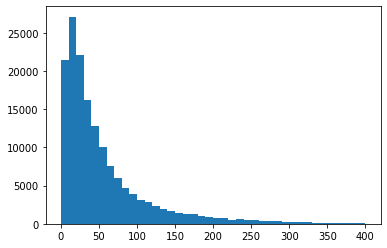

In [17]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

- 대부분의 문장 길이는 약 30개 이상이다. 
- "maxlen"을 약 50으로 설정할 수 있지만, 200으로 할 것.

## modeling

![imag](https://i.imgur.com/txJomEa.png)

- input layer
  - by indication an empty space after comma -> keras infer the number automatically

In [18]:
inp = Input(shape=(maxlen, ))

- embedding layer
  - we need to difine the **size of the "vector space"** and **number of unique words(max_features)**

In [19]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

- embedding layer는 3차원 tensor (none, 200, 128)
  - array of sentence : none(means that it's size if inferred)
  - for each words(200), there if an array of 128 coordinates in the vector space of embedding.

- LSTM layer
  - output : 60 dim 
  - it to return the whole unrolled sequence of results
  - [Batch Size, Time Steps, Number of Inputs]
    - Batch size : the number of samples in a batch
    - time steps : the number of recursion it runs for each input,
    - number of inputs : the number of variables(number of words in each sentence in our case) 
  - (None, 200, 60) 형태가 receive 될 것임.

In [20]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

- output을 normal layer로 전달하기 전에, 3차원을 2차원으로 reshape 필요.
  - 과정에서 데이터 손실 주의
- CNN problems 에서 image data의 dim을 줄이기 위해 전통적으로 **Global Max pooling layer** 이용
  - each patch of data를 보고 , take the maximum values of each patch.
  - these collection of maimum values will be new set of down-sized data we can use.


In [21]:
x = GlobalMaxPool1D()(x)

- dropout layer
  - 2D tensor를 pass 시킴.
    - 일부 nodes를 무분별하게 "disable" 시키고 next layer의 nodes가 missing data 표현을 처리하도록 함.
  - We set the dropout layer to drop out **10%(0.1)** of the nodes.

In [22]:
x = Dropout(0.1)(x)

- dense layer
  - dropout layer의 output을 **densely connected layer**에 연결하고, output을 **RELU function**을 통과.
  - **activation((input X weights) + bias)**
  - dense layer의 output dim = 50으로 정의

In [23]:
x = Dense(50, activation="relu")(x)

- dropout layer
  - we feed the output into a Dropout layer again.

In [24]:
x = Dropout(0.1)(x)

- sigmoid layer
  - 6 labels 각각에 이진 분류


In [25]:
x = Dense(6, activation="sigmoid")(x)

-  Adam optimizer : 손실 함수를 최적화
- loss function : "binary_crossentropy
- learning rate : default 0.001

In [26]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

## test

- 각 배치에 대해 32개의 패딩된 색인화된 문장 목록 제공
- 데이터의 10%를 검증 세트로 분할
- validation set : 모형이 각 배치에 대해 과도하게 적합되었는지 여부를 평가하는 데 사용
- 2 epoch 

In [27]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 661s 147ms/step - loss: 0.0695 - accuracy: 0.9535 - val_loss: 0.0491 - val_accuracy: 0.9936
Epoch 2/2
4488/4488 [==============================] - 654s 146ms/step - loss: 0.0450 - accuracy: 0.9915 - val_loss: 0.0469 - val_accuracy: 0.9935


## tips

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           45360     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                             